## Линейная регрессия

---

В этом задании нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

### Часть 1: Предобработка данных (2 балла)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Задание 1.** Загрузите данные из файла `weatherHistory.csv`. Выведите первые 5 строк таблицы.

In [2]:
import pandas as pd
df = pd.read_csv('weatherHistory.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


**Задание 2.** Изучите статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index"). Удалите какую-то переменную из набора данных и поясните, почему вы её удалили (помните о том, какая переменная будет целевой). Также удалите переменные:
- `Formatted Date` (потому что договорились, что не обращаем внимания на даты).
- `Daily Summary` (будем использовать просто `Summary`). 

In [3]:
del df['Formatted Date']
del df['Daily Summary']
del df['Apparent Temperature (C)'] # удаляем также эту, так как она не оказывает влияние на нашу зависимую переменную

**Задание 3.** Есть ли в наборе данных пропущенные значения? Если да, удалите их.

In [4]:
df.isnull().sum() # видим, что у нас 517 пропущенных значений в Precip Type
df=df.dropna()
df.head()

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


**Задание 4.** В данных есть одна числовая переменная, которая не несёт информации для предсказания целевой переменной. Найдите эту переменную, поясните ваш выбор и удалите её. 

In [5]:
# удаляем переменную Loud Cover тк она имеет только одно уникальное значение - 0, что говорит об отсутствии облачного покрытия, следоватеьно мы не можем использовать его в дальнейшем анализе
df.drop('Loud Cover', axis=1, inplace=True)
fill_mean=df[df['Pressure (millibars)']!=0]['Pressure (millibars)'].mean()
df['Pressure (millibars)'].replace(0,fill_mean, inplace=True)

In [6]:
target='Temperature (C)'
categ =['Summary','Precip Type']
real = ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)','Pressure (millibars)']


**Задание 5.** Постройте диаграммы рассеяния всех числовых переменных против целевой (для этого используйте какой-то метод из `seaborn`). Есть ли переменные, для которых наблюдается очевидная нелинейная зависимость?

**Подсказка:** это пригодится для частей 2 и 3.

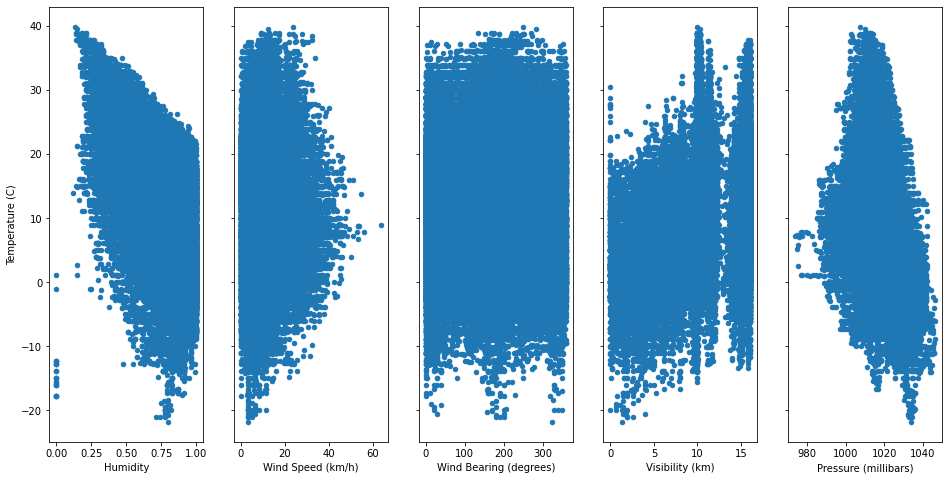

In [7]:
fig, axs = plt.subplots(1, 5, sharey=True)
df.plot(kind='scatter', x='Humidity', y='Temperature (C)', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='Wind Speed (km/h)', y='Temperature (C)', ax=axs[1])
df.plot(kind='scatter', x='Wind Bearing (degrees)', y='Temperature (C)', ax=axs[2])
df.plot(kind='scatter', x='Visibility (km)', y='Temperature (C)', ax=axs[3])
df.plot(kind='scatter', x='Pressure (millibars)', y='Temperature (C)', ax=axs[4])




plt.show()
# источник: семинар 10
# видим, что из очевидного, можно рассмотреть нелинейную зависимость между температурой и влажностью

**Задание 6.** Преобразуйте категориальные переменные при помощи One Hot Encoding (то есть переведите их в дамми-переменные).

источник: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [8]:
df = pd.get_dummies(df, columns=categ, dummy_na=False)
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_rain,Precip Type_snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**Задание 7.** Выведите корреляционную матрицу переменных. Какие переменные лучше всего коррелируют с целевой (назовите три)? 

**Подсказка:** это пригодится для частей 2 и 3.

In [9]:
df[real+[target]].corr()

,Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Temperature (C)
Humidity,1.000000,-0.224569,0.000814,-0.370511,0.038418,-0.632148
Wind Speed (km/h),-0.224569,1.000000,0.104366,0.100801,-0.252751,0.008304
Wind Bearing (degrees),0.000814,0.104366,1.000000,0.048900,-0.078024,0.029937
Visibility (km),-0.370511,0.100801,0.048900,1.000000,-0.161561,0.393719
Pressure (millibars),0.038418,-0.252751,-0.078024,-0.161561,1.000000,-0.308111
Temperature (C),-0.632148,0.008304,0.029937,0.393719,-0.308111,1.000000


<AxesSubplot:>

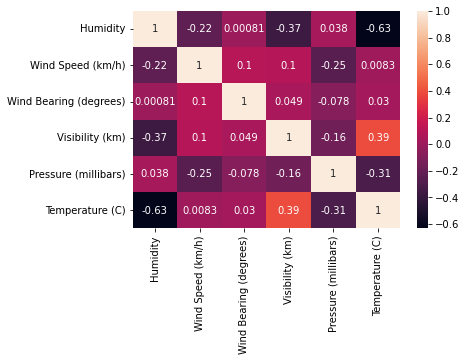

In [10]:
# итак наибольшая корреляция между целевой переменной-температурой- и влажностью, видимостью и скоростью ветра
sns.heatmap(df[real+[target]].corr(),annot=True)

**Задание 8.** Разделите данные на регрессоры (`X`) и целевую переменную (`y`). Если всё сделано правильно, то `X` и `y` должны иметь размеры, указанные ниже.

In [11]:
X = df.drop('Temperature (C)', axis =1)
y = df['Temperature (C)']

In [12]:
print('X:', X.shape)
print('y:', y.shape)

# мои

X: (95936, 34)
y: (95936,)


In [13]:
print('X:', X.shape)
print('y:', y.shape)
# нужные

X: (95936, 34)
y: (95936,)


**Задание 8.** Похоже ли распределение целевой переменной на нормальное? Поясните, почему важно, чтобы распределение `y` было похоже на нормальное.

<AxesSubplot:>

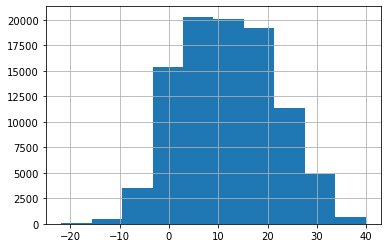

In [14]:
df[target].hist()
# видим, что распределение похоже на нормальное, это означает что переменная сохраняет стадартную дисперсию и вероятность ошибки, без которой мы могли бы получить неправильные описания зависимостей для ЦП нашей модели

### Часть 2: Построение объясняющей модели (4 балла)

**Задание 9.** На основании предыдущего анализа и логических соображений выберите шесть регрессоров (не считая константный), которые будут включены в объясняющую модель. Помните, что когда мы строим объясняющую модель, выбор переменных должнен быть обоснован (не достаточно использовать предыдущий анализ, выбор каждой переменной должен иметь теоретическое или логическое обоснование). В качестве регрессоров можно брать переменные из `X` или преобразования над ними (`Humidity` и `Humidity`$^2$ будем считать разными регрессорами). 

Создайте ячейку Markdown ниже и запишите в неё функциональный вид модели, которую вы будете оценивать. Поясните выбор регрессоров (не нужно углубляться в физику поведения жидкостей и ссылаться на уравнения Навье-Стокса, достаточно понятной научно-популярной интерпретации) и, если используете, выбор нелинейных преобразований над ними.

**Пример ответа:** я строю модель

$$
y_i = \beta_0 + \beta_1 Humidity + \beta_2 Humidity^2 + \beta_3 Humidity^3 + \beta_4 Visibility (km) + \beta_5 Visibility (km) ^ 2 + \beta_6 Summary\_Breezy + \varepsilon_i
$$

Обоснование выбора переменных:
- $Humidity$ – потому что мне кажется, что влажность воздуха влияет на температуру <так-то и так-то>.
- $Humidity^2$ – потому что ...
- ...

In [ ]:
new_col=df['Humidity']**2
df['squared_Humidity'] = new_col

new_col1=df['Pressure (millibars)']**2
df['squared_Pressure'] = new_col1

In [16]:
df['Precip_Type_snow']=df['Precip Type_snow']
df['Wind_Speed_km_h']=df['Wind Speed (km/h)']
df['Wind_Bearing_degrees']=df['Wind Bearing (degrees)']
df['Pressure_millibars']=df['Pressure (millibars)']
df['Temperature_C']=df['Temperature (C)']
df['Visibility']=df['Visibility (km)']

В качестве регрессоров для модели я использую 

1)Humidity, так как мне кажется, что влажность положительно влияет на температуру, что особенно ощутимо при высоком показателе целевой переменной(цп) 

2)Precip Type_snow, потому что считаю, что на температуру определенно влияет сезонность, а снежные осадки характерны для Венгрии в холодное время года

3)Wind Bearing (degrees), потому что считаю, что направление ветра говорит о состоянии атмосферного фронта, что может помочь нам в описании температуры

4)Pressure (millibars), потому что мне кажется, что давление влияет на температуру так как при понижении давления может понизится температура

5)squared_Humidity, потому что мне кажется что влажность при экстремальных температурах может оказывать нелинейную зависимость

6)squared_Pressure, так как мне кажется, что из-за повышения давления понижается облачность вследствие чего летом температура повышается, в то время как в холодное время температур при том же отсутствии облачности температура меньше, из-за чего имеет место нелинейная зависимость

**𝑦𝑖=𝛽0+𝛽1𝐻𝑢𝑚𝑖𝑑𝑖𝑡𝑦+𝛽2Precip Type_snow+𝛽3Wind Bearing (degrees)+𝛽4Pressure (millibars)+𝛽Humidity^2+𝛽6Pressure^2𝑦+𝜀𝑖**
 


**Задание 10.** Выделите выбранные признаки в переменную `X1`. 

In [17]:
X1=['Humidity', 'Precip_Type_snow', 'Wind_Bearing_degrees', 'Pressure_millibars', 'squared_Pressure', 'squared_Humidity']

**Задание 11.** Оцените модель при помощи МНК (минимзации MSE). Прокомментируйте значимость коэффициентов.

In [18]:
import statsmodels.formula.api as smf
modie = smf.ols(formula='Temperature_C ~ Humidity + Precip_Type_snow + Wind_Bearing_degrees + Pressure_millibars + squared_Pressure +squared_Humidity', data=df).fit()
modie.params

Intercept              -12824.553706
Humidity                  -54.612158
Precip_Type_snow          -11.098509
Wind_Bearing_degrees       -0.000257
Pressure_millibars         25.522369
squared_Pressure           -0.012656
squared_Humidity           22.020955
dtype: float64

**Задание 12.** Поясните, как каждый регрессор влияет на зависимую переменную 
1. математически ("при увеличении $X$ на 1 $Y$ увеличивается на 3") и 
2. содержательно ("$X$ влияет на $Y$ положительно, потому что...", "$X$ не оказывает влияния на $Y$, потому что...").

1)при увеличении humidity на 1 мы получили, что значение температуры( Y) снижается на 54,6 2) то есть влажность отрицательно влияет на  температуру, так как при высокой влажности показатели температуры снижаются

1)при увеличении precip_type_snow на 1 мы получили, что значение температуры(Y)снижается на 11,1 2) то есть наличие снега отрицательно влияет на температуру, потому что для его наличие необходимо выполнение холодной температуры воздуха 

1)при увеличении Wind_Bearing_degrees на 1, значение Y уменьшается  на 0,0003 2) можно сказать что влияние X на Y не оказывается, то есть направление ветра не оказывает влияния на температуру

1)при увеличении Pressure_millibars на 1, значение Y увеличивается на 26 2) то есть давление положительно влияет на температуру, потому что с ростом давления растет температура

1)при увеличении squared_Pressure на 1, значение Y снижается  на 0,012 2) то есть квадратичное давление в целом не влияет на температуру

1)при увеличении squared_Humidity на 1, значение Y увеличиваетя  на 22 2) то есть влажность оказывает положительное и также нелинейное влияние на температуру в том числе

**Задание 13.** Рассчитайте $R^2$ и MSE на выборке `X1`. Прокомментируйте качество подгонки регрессии.

In [19]:
modie.rsquared

# получившийся R^2 свидетельтсвует, что наша модель объясняется на 63% включенными в неефакторами, что является относительно неплохим показателем

0.6342583674651844

In [20]:
#источник: семинар 11
from sklearn.metrics import mean_squared_error
def mse_detected(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

from sklearn.linear_model import LinearRegression
modmod = LinearRegression()
modmod.fit(X, y)
y_pred = modmod.predict(X)
print('MSE: ', mse_detected(y, y_pred))

MSE:  5.614040496008954


### Часть 3: Построение предсказательной модели (4 балла)

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. Код ниже поделит выборку (`X`, `y`) на обучающую (`X_train`, `y_train`), на которой будем *оценивать* модель, и *тестовую* (`X_test`, `y_test`), на которой будем предсказывать. 

In [21]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

**Задание 14.** Сохраните в переменные `X_train_1` и `X_test_1` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9).

Оцените модель на выборке `X_train_1`. Сделайте предсказания на выборках `X_train_1` (то есть обучающей) и `X_test_1` (то есть тестовой). Рассчитайте `MAE` на этих выборках.

In [25]:
X_train_1=X_train.copy()
X_test_1=X_test.copy()

from sklearn.linear_model import LinearRegression
linr= LinearRegression()
linr.fit(X_train, y_train)

linr.fit(X_train_1, y_train)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print('MAE_first: ')
print(mean_absolute_error(y_train, linr.predict(X_train_1)))


MAE_first: 
4.572867602974942


**Задание 15.** Теперь сохраните в переменные `X_train_2` и `X_test_2` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9) и ещё какие-то признаки (количество выберите на ваш вкус, главное, чтобы всего признаков было больше, чем в `X1`). Оцените модель на выборке `X_train_2`. Сделайте предсказания на выборках `X_train_2` (то есть обучающей) и `X_test_2` (то есть тестовой). Рассчитайте `MAE` на этих выборках. Удалось ли повысить качество на обучающей выборке? А на тестовой? Поясните. 

В качестве новых признаков добавим Wind Speed и Visibility не учтенные раннее, так как возможно именно они позволят получить более комплексное объяснение модели и, как следствие, меньшую абсолютную ошибку 

In [23]:
X_train_2=X_train.copy()
X_train_2=X_train[['Humidity', 'Precip Type_snow', 'Wind Bearing (degrees)', 'Pressure (millibars)', 'Wind Speed (km/h)','Visibility (km)']]
X_train_2['squared_Pressure']=df ['squared_Pressure']
X_train_2['squared_Humidity']=df['squared_Humidity']

X_test_2=X_test.copy()
X_test_2=X_test[['Humidity', 'Precip Type_snow', 'Wind Bearing (degrees)', 'Pressure (millibars)', 'Wind Speed (km/h)','Visibility (km)']]
X_test_2['squared_Pressure']=df['squared_Pressure']
X_test_2['squared_Humidity']=df ['squared_Humidity']                  

/var/folders/mp/4ncxpf7d2wg2lslq6lky9swh0000gn/T/ipykernel_27777/1611929106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['squared_Pressure']=df ['squared_Pressure']
/var/folders/mp/4ncxpf7d2wg2lslq6lky9swh0000gn/T/ipykernel_27777/1611929106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['squared_Humidity']=df['squared_Humidity']
/var/folders/mp/4ncxpf7d2wg2lslq6lky9swh0000gn/T/ipykernel_27777/1611929106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [33]:
from sklearn.metrics import mean_absolute_error
print('new_MAE: ')
mean_absolute_error(y_test,linr.predict(X_test_2)) 
# видим, что хотя и не намного, но ошибка нашей новой модели снизилась, значит добавленные признаки так или иначе несут описательный характер для нашей ЦП

new_MAE: 


4.494155039836225

In [42]:
X_train_2.head()

,Humidity,Precip Type_snow,Wind Bearing (degrees),Pressure (millibars),Wind Speed (km/h),Visibility (km),squared_Pressure,squared_Humidity
27834,0.92,0,220.0,1022.20,3.2200,9.9820,1.044893e+06,0.8464
53975,0.55,0,140.0,1011.93,10.6421,15.3111,1.024002e+06,0.3025
29076,0.77,0,160.0,1000.10,16.1000,9.9820,1.000200e+06,0.5929
46036,0.87,1,199.0,1025.04,5.2486,9.9820,1.050707e+06,0.7569
39655,0.73,0,39.0,1016.44,15.3433,9.9820,1.033150e+06,0.5329


**Задание 16.** Прокомментируйте значимость коэффициентов модели, оценённой на `X_train_2`.

In [47]:
df['Precip_Type_snow']=df['Precip Type_snow']
df['Wind_Speed_km_h']=df['Wind Speed (km/h)']
df['Wind_Bearing_degrees']=df['Wind Bearing (degrees)']
df['Pressure_millibars']=df['Pressure (millibars)']
df['Temperature_C']=df['Temperature (C)']
df['Visibility']=df['Visibility (km)']

In [50]:
modie_new = smf.ols(formula='Temperature_C ~ Humidity+ Precip_Type_snow+Wind_Bearing_degrees+Pressure_millibars+Wind_Speed_km_h+Visibility+ squared_Pressure+squared_Humidity', data=df).fit()
modie_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Temperature_C   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 2.419e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:18:24   Log-Likelihood:            -2.9985e+05
No. Observations:               95936   AIC:                         5.997e+05
Df Residuals:                   95927   BIC:                         5.998e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.056e+04    187.672    -56.272      0.000   -1.09e+04   -1.02e+04
Humidity               -57.0453      0.661    -86.311      0.000     -58.341     -55.750
Precip_Type_snow       -10.3512      0.064   -162.928      0.000     -10.476     -10.227
Wind_Bearing_degrees     0.0010      0.000      5.776      0.000       0.001       0.001
Pressure_millibars      21.1209      0.369     57.217      0.000      20.397      21.844
Wind_Speed_km_h         -0.2513      0.003    -90.202      0.000      -0.257      -0.246
Visibility               0.1905      0.005     36.651      0.000       0.180       0.201
squared_Pressure        -0.0105      0.000    -57.933      0.000      -0.011      -0.010
squared_Humidity        23.1871      0.505     45.878      0.000      22.197      24.178
==============================================================================
Omnibus:                     1476.989   Durbin-Watson:                   0.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1616.405
Skew:                          -0.277   Prob(JB):                         0.00
Kurtosis:                       3.311   Cond. No.                     1.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Данный вид модели имеет более высокий R квадрат в сравнении с первой, что говорит о лучшем соответствии исходным данным нежели изначальная модель

При этом все также влажность оказывает наибольшее отрицательное влияние на температуру, при проверке данного регрессора в квадратичном виде, зависимсть также присутствует, но уже положительная, что позволяет привснизить иные факторы в данной взаимосвязи(как уже упомяналось, например, время года)


Также для отобранных нами для анализа переменных характерна зависимость между нецелевыми переменными, что осложняет рассматривание ситуации применитетельно к ЦП

**Задание 17.** Будем называть модель, оценённую на `X_train_1`, **объясняющей**, а на `X_train_2` – **предсказательной**. На основании заданий 14 и 15 сделайте вывод, подходит ли объясняющая модель для предсказаний. На основании задания 16 сделайте вывод, подходит ли предсказательная модель для объяснительной интерпретации. 

Можно сказать, что технически X_train_1(объясняющая) подходит для предсказаний меньше нежели следующая модель, однако в нашем случае разница в ошибках составила не критичное значение, то есть несмотря на то, что мы снизили MAE и при прочих равных выбрали бы вторую модель, первая также может подойти для предсказаний

Говоря о X_train_2(предсказательной), она в целом объясняет зависимости ЦП лучше и, следовательно, подходит для осмысленной интерпретации, особенно при условии, что унифицированного значения границы "хорошего" и "плохого" R квадрат не существует

## Safe Area

Если хотите, напишите здесь что угодно. Можно вставить картинку.